In [18]:
import matplotlib.pyplot as pp
import numpy as np
import math

In [19]:
def fitset(data):    
    #data = dt_to_spm(data)

    points = np.array(dt_to_spm(data))
    x = points[:,0] #extract x and y's from points set
    y = points[:,1]

    fiteq = points_to_log(data)
    x_c = np.linspace(0.01,max(x),100)
    y_c = fiteq.f(x_c)

    pp.plot(x,y,'x')
    pp.plot(x_c,y_c,'o')
    pp.show()

In [20]:
#from eq6 - converts time based coordinate set to pace based, and back

def dt_to_spm(old_set):
    new_set = []
    for old_tuple in old_set:
        if old_tuple[0]!=0:
            new_tuple = (old_tuple[0],old_tuple[1]/old_tuple[0])
            new_set.append(new_tuple)
        else:
            new_tuple = (old_tuple[0],old_tuple[1]/0.00001)
            new_set.append(new_tuple)
    return new_set

def spm_to_dt(old_set):
    new_set = []
    for old_tuple in old_set:
        new_tuple = (old_tuple[0],old_tuple[1]*old_tuple[0])
        new_set.append(new_tuple)
    return new_set

def minsec(minutes,seconds):
    return (minutes*60)+seconds
def hourminsec(hours,minutes,seconds):
    return (hours*3600)+(minutes*60)+seconds

In [21]:
def points_to_log(points):
    pts = np.array(dt_to_spm(points))
    x = pts[:,0] #extract x and y's from points set
    y = pts[:,1]
    fit = np.polyfit(np.log(x), y, 1)# determining polynomial
    return log_eq(fit)

In [22]:
class log_eq():
    def __init__(self,args):
        self.a = args[0]
        self.b = args[1]
        #print(self.f(5))
        #print("----")
        
        
    def f(self,x):
        return self.b+np.log(x)*self.a 

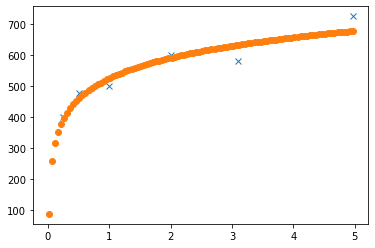

In [23]:
derp_shit = [(0.25, 100),(0.5, 240),(1, 500),(2, 1200),(3.1, 1800),(4.97, 3610)]
fitset(derp_shit)

In [71]:
#from eq8 - selects and uses data points that offer fastest pace curve. Simplified and modified here
class curator():
    def __init__(self):
        print("creating data point curator")
        self.activities = []
        
        self.included = []
        self.excluded = []
            
            
    def add_activity(self,act):
        self.activities.append(act)
        #if len(self.activities)>=3: 
            #print("skipping auto-evaluate. currently only prompting manually")
            #print(len(self.activities))
            #self.evaluate_all()
            
    def add_data(self,data):
        self.activities.append(activity(data[0],data[1]))
        #if len(self.activities)>=3: 
            #print("skipping auto-evaluate. currently only prompting manually")
            #print(len(self.activities))
            #self.evaluate_all()
            
            
    def evaluate_all(self): ####### FACTOR IN WEIGHT OF GAP DEPENDING ON D. GAP IS MORE RELEVANT FOR LOWER D VALUES        
        #EITHER DIVIDE GAP BY D TO DETERMINE HOW MUCH OF AN IMPACT THAT OUTLIER MAKES?
        #OR MULTIPLY GAP BY D AS TO GIVE WEIGHT TO SORT RELEVANCE
            
        points = []
        for a in self.activities:
            points.append(a.use())
    
        main_curve = points_to_log(points)        
        
        for i in range(len(points)):
            y_c = main_curve.f(points[i][0])
            y_p = points[i][1]
            
            y_shift = (y_p - y_c)#/(points[i][0])
            self.activities[i].value = y_shift/(points[i][0])
            print("("+str(self.activities[i].d)+"/"+str(self.activities[i].t)+") shifted "+str(y_shift)+" from the curve")
        val_sort(self.activities)
        return
            
            
            
    def evaluate_all_old(self):
            
        points = []
        for a in self.activities:
            points.append(a.use())
    
        main_curve = points_to_log(points)        
        
        for i in range(len(points)):
            graphable = points[:i]+points[i+1:]
            new_curve = points_to_log(graphable)
            
            y_with = main_curve.f(points[i][0])
            y_without = new_curve.f(points[i][0])
            print("with: "+ str(y_with)+"     Without: "+ str(y_without))
            
            #print("compare Ys: "+str(y_with)+" - "+y_without)
            value = y_without - y_with
                    
            self.activities[i].value = value
            print("("+str(self.activities[i].d)+"/"+str(self.activities[i].t)+") has estimated value of "+str(value))
        val_sort(self.activities)
        
        
    def value_plot(self,portion):
        if portion>1 or portion<0:
            print("invalid slice, defaulting to .5")
            portion=0.5
        divider = int(len(self.activities) * portion)
        
        slowlist = self.activities[0:divider-1]
        fastlist = self.activities[divider:]
        
        self.included = fastlist
        self.excluded = slowlist
        
        for i in range(len(slowlist)):
            slowlist[i] = slowlist[i].use()
            
        for i in range(len(fastlist)):
            fastlist[i] = fastlist[i].use()
            
        plot_tfd_times([fastlist,slowlist])
        
    def select_portion(self,portion):
        if portion>1 or portion<0:
            print("invalid slice, defaulting to .5")
            portion=0.5
        divider = int(len(self.activities) * portion)
        fastlist = self.activities[divider:]
        self.included = fastlist

        for i in range(len(fastlist)):
            fastlist[i] = fastlist[i].use()
            
            
        return fastlist

        

In [72]:
#from eq8 - represents a single activity along with curation value. Simplified and modified here

class activity():
    def __init__(self,dist,time):
        #self.using = False
        self.value = 1
        
        self.d = dist
        self.t = time
        self.spm = time/dist
        
    def use(self): #return graphable coordinate pair
        return (self.d,self.spm)

In [73]:
#sorts activity array by value
def val_sort(arr):
    s = val_split(arr,0,len(arr)-1)
    val_sort2(arr,s+1,len(arr)-1)
    val_sort2(arr,0,s-1)
    return arr

def val_sort2(arr, _min, _max):
    if _min<_max:
        s = val_split(arr,_min,_max)
        val_sort2(arr,s+1,_max)
        val_sort2(arr,_min,s-1)
    return arr

def val_split(arr, _min, _max):
    pivot = arr[_max]
    print(pivot.value)
    #print(arr)
    #pivot = arr[len(arr)-1]
    i = _min - 1
    for j in range(_min, _max):
        print(pivot.value)
        if arr[j].value <= pivot.value:
            i+=1
            (arr[i], arr[j]) = (arr[j], arr[i])
    (arr[i + 1], arr[_max]) = (arr[_max], arr[i + 1])
    return i+1

In [74]:
#from eq6 - predict time or pace for run given set of previous efforts
def predict_pace(dt_pairs,distance): #expects [:,1] to be total time, not tpm.  
    pace_pairs = dt_to_spm(dt_pairs) # (distance,spm)
    eq6 = pacefit_pace(pace_pairs)
    return(eq6(distance))

def get_fit_eq(dt_pairs): #expects [:,1] to be total time, not tpm.  
    pace_pairs = dt_to_spm(dt_pairs) # (distance,spm)
    eq6 = pacefit_pace(pace_pairs)
    return(eq6)

def predict_time(dt_pairs,distance):
    return predict_pace(dt_pairs,distance)*distance

In [75]:
#From eq6 - uses pace curve to determine predicted run time. Methods for time and pace based
def pacefit_times(times):
    paces = dt_to_spm(times)
    paces_np = np.array(paces)
    return pf3(paces_np)

def pacefit_pace(paces):
    paces_np = np.array(paces)
    return pf3(paces_np)

def pf3(distance_pace):
    x = distance_pace[:,0]  #get x from tuples
    y = distance_pace[:,1]  #get y from tuples
    p = np.polyfit(x, y, 2) #get polyfit outcome
    f = np.poly1d(p)        #get function
    return f

In [76]:
#from eq5 - plot run efforts by time or pace

def pacelines(paces):
    for pace in paces:
        pp.plot([0,6],[pace*60,pace*60],lw='2',color = '#aaaaaa')
        
def altgraph(tuples):
    pacelines([3,4,5,6])
    xdata = []
    ydata = []
    for t in tuples:
        xdata.append(t[0])
        ydata.append(t[1]/(t[0]+0.00001))
    print(xdata)
    print(ydata)
    pp.scatter(xdata,ydata)
    pp.show()

def plot_dpr_paces(sets):
    pacelines([3,4,5,6])
    count = 0
    for s in sets:
        count+=1
        xdata = []
        ydata = []
        for ss in s:
            xdata.append(ss[0])
            if ss[0]==0:
                ydata.append(ss[1]/0.00001)
            else:
                ydata.append(ss[1]/ss[0])
            
        pp.scatter(xdata,ydata,marker="o",color = getcolor(count))
        #pp.plot(xdata,ydata,lw='2',marker="o",color = getcolor(count))
    pp.title("Expected pace from distance") 
    pp.show()
    
def plot_tfd_times(sets):
    count = 0
    for s in sets:
        count+=1
        xdata = []
        ydata = []
        for ss in s:
            xdata.append(ss[0])            
            ydata.append(ss[1])
        pp.scatter(xdata,ydata,marker="o",color = getcolor(count))

        #pp.plot(xdata,ydata,lw='2',marker="o",color = getcolor(count))
    pp.title("Plotting time against distance") 

    pp.show()

    
def getcolor(i):
    if i==None:
        return hex6()
    elif i==-1:
        return 'black'
    elif i==1:
        return 'red'
    elif i==2:
        return 'blue'
    elif i==3:
        return 'green'
    elif i==4:
        return 'purple'
    elif i==5:
        return 'orange'
    else:
        return 'gray'

def hex6():    
    col = '#'
    while len(col)<7:
        val = ra.randint(0,15)
        if val<10:
            col+=str(val)
        else:
            col+=chr(87+val)
    return col

def ms(minutes,seconds):
    return (minutes*60)+seconds

def hms(hours,minutes,seconds):
    return (hours*3600)+(minutes*60)+seconds
        

In [77]:
wr_set = [(0.25, 43),(0.5, 101),(1, 223),(2, 478),(3.1, 750),(4.97, 1264)] # world records 400m to 5000m
jm_set = [(0.25, 54),(0.5, 120),(1, 275),(2, 600),(2.5, 960),(3.1, 960),(4.97, 1610)] # ya boy
ms_set = [(0.25, 55),(0.5, 121),(1, 272),         (3.1, 925),(4.97, 1560)] # max, naturally

allsets = wr_set + jm_set + ms_set

In [78]:
def queuefit(data):    
    #data = dt_to_spm(data)

    points = np.array(dt_to_spm(data))
    x = points[:,0] #extract x and y's from points set
    y = points[:,1]

    fiteq = points_to_log(data)
    x_c = np.linspace(0.01,max(x),30)
    y_c = fiteq.f(x_c)
    pp.plot(x_c,y_c,'o',color="#555555")


creating data point curator
(0.25/43) shifted -519.7526448274236 from the curve
(0.5/101) shifted -323.59987932326135 from the curve
(1/223) shifted -136.4471138190989 from the curve
(2/478) shifted 45.705651685063515 from the curve
(3.1/750) shifted 153.69424810165702 from the curve
(4.97/1264) shifted 279.2310374808427 from the curve
(0.25/54) shifted -475.75264482742364 from the curve
(0.5/120) shifted -285.59987932326135 from the curve
(1/275) shifted -84.44711381909889 from the curve
(2/600) shifted 106.70565168506351 from the curve
(2.5/960) shifted 244.19489494408518 from the curve
(3.1/960) shifted 221.436183585528 from the curve
(4.97/1610) shifted 348.8487437182672 from the curve
(0.25/55) shifted -471.75264482742364 from the curve
(0.5/121) shifted -283.59987932326135 from the curve
(1/272) shifted -87.44711381909889 from the curve
(3.1/925) shifted 210.14586100488282 from the curve
(4.97/1560) shifted 338.788381545229 from the curve
68.16667636724931
68.16667636724931
68.16

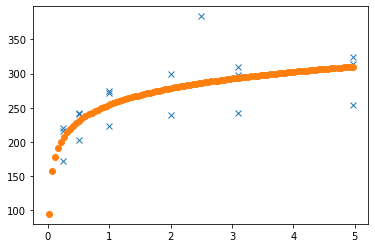

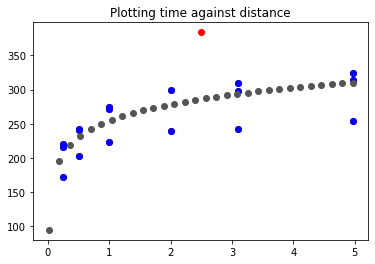

0.1


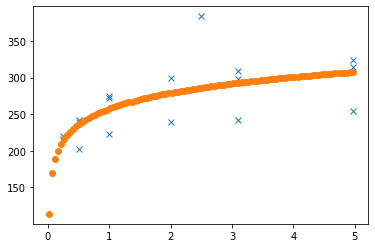

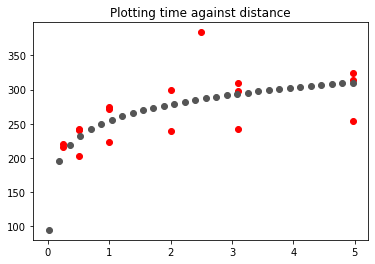

0.2


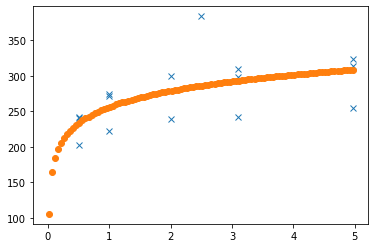

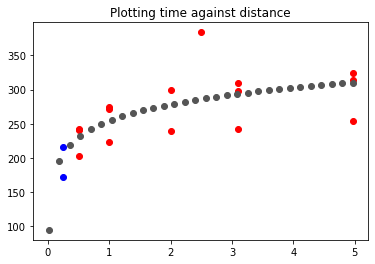

0.3


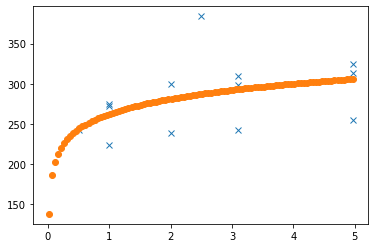

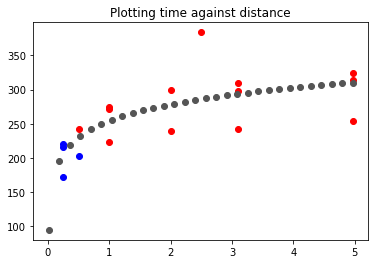

0.4


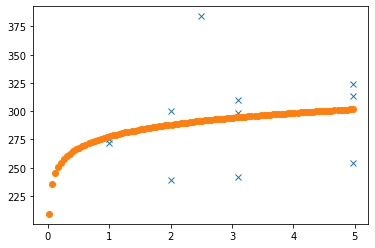

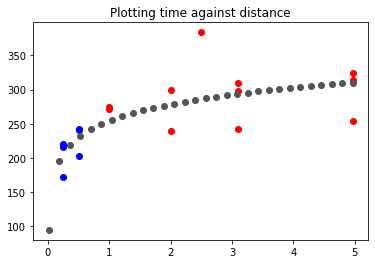

0.5


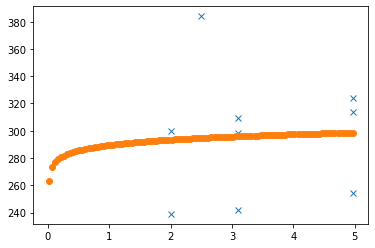

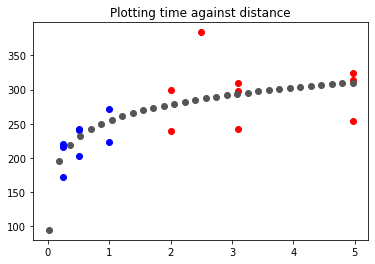

0.6


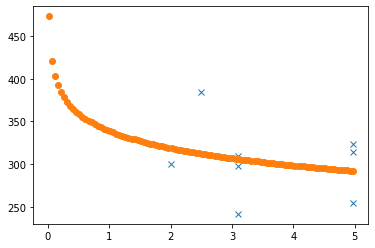

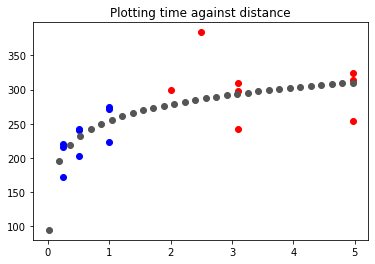

0.7


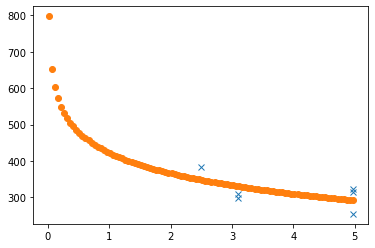

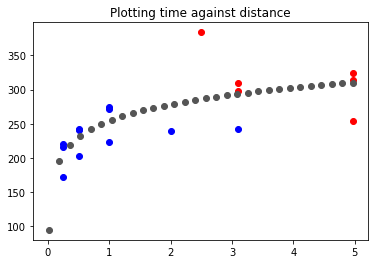

0.8


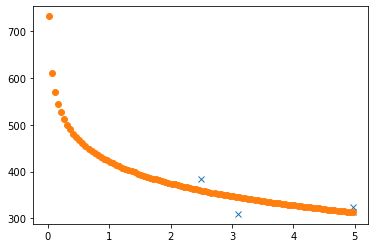

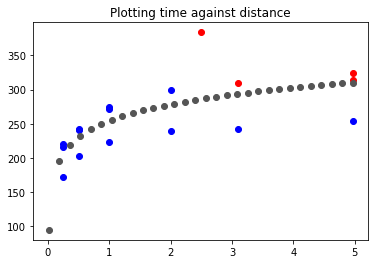

0.9


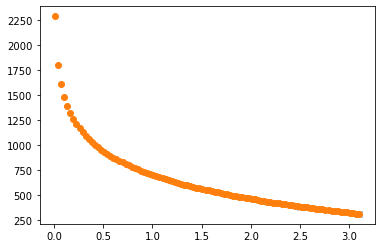

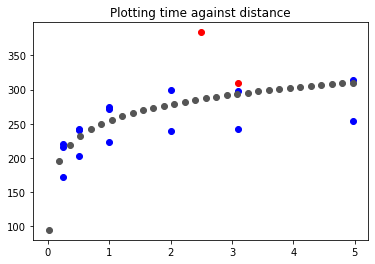

In [88]:
def curation_test_5(points):
    
    #create curator and store all points as activity wrappers
    c = curator()
    for p in points:
        c.add_activity(activity(p[0],p[1]))
    #evaluate points, sorted by value. Iterate and plot for 10 point selection sizes
    c.evaluate_all()
    for i in range(0,10,1):
        print(i/10)
    
        selected = c.select_portion(i/10)
        fitset(spm_to_dt(selected))

        #queuefit(selected)
        queuefit(allsets) 
        c.value_plot(i/10)
curation_test_5(allsets)

In [69]:
def compare_athletes(set1,set2,dist): #given two athletes and a segment, determine whether athlete 1 can beat athlete 1's time
    #c1 = curator()
    #c2 = curator()
    #c1.add_data(set1)
    #c2.add_data(set2)
    #c1.evaluate_all()
    #c2.evaluate_all()
    #c1.value_plot()
    #set1 = c1.included
    #set2 = c2.included

    a1 = points_to_log(set1)
    a2 = points_to_log(set2)    
    
    t1 = a1.f(dist)
    t2 = a2.f(dist)
    print(t1)
    print(t2)
    
    return t1<=t2

    

In [70]:
compare_athletes(jm_set,ms_set,3)

326.76145216977386
299.3266592389058


False

creating data point curator
(0.25/43) shifted -519.7526448274236 from the curve
(0.5/101) shifted -323.59987932326135 from the curve
(1/223) shifted -136.4471138190989 from the curve
(2/478) shifted 45.705651685063515 from the curve
(3.1/750) shifted 153.69424810165702 from the curve
(4.97/1264) shifted 279.2310374808427 from the curve
(0.25/54) shifted -475.75264482742364 from the curve
(0.5/120) shifted -285.59987932326135 from the curve
(1/275) shifted -84.44711381909889 from the curve
(2/600) shifted 106.70565168506351 from the curve
(2.5/960) shifted 244.19489494408518 from the curve
(3.1/960) shifted 221.436183585528 from the curve
(4.97/1610) shifted 348.8487437182672 from the curve
(0.25/55) shifted -471.75264482742364 from the curve
(0.5/121) shifted -283.59987932326135 from the curve
(1/272) shifted -87.44711381909889 from the curve
(3.1/925) shifted 210.14586100488282 from the curve
(4.97/1560) shifted 338.788381545229 from the curve
68.16667636724931
68.16667636724931
68.16

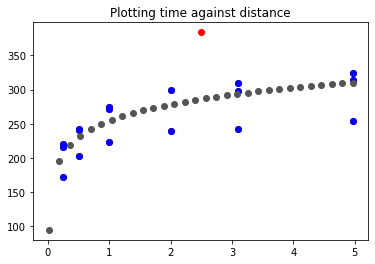

0.1


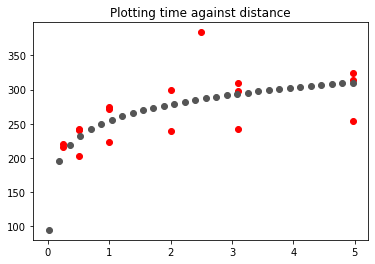

0.2


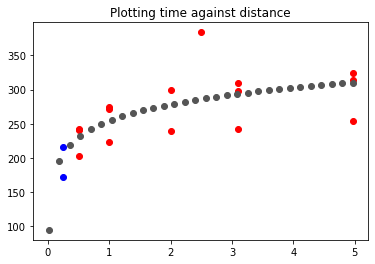

0.3


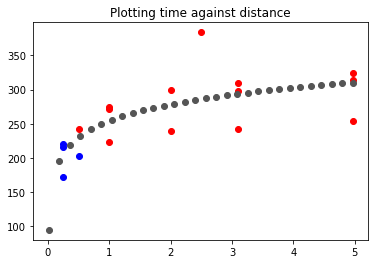

0.4


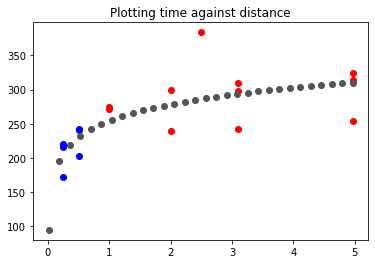

0.5


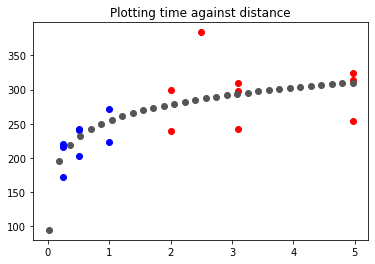

0.6


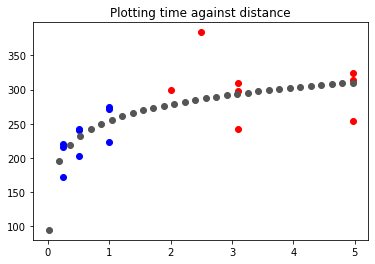

0.7


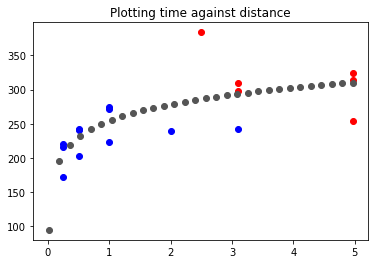

0.8


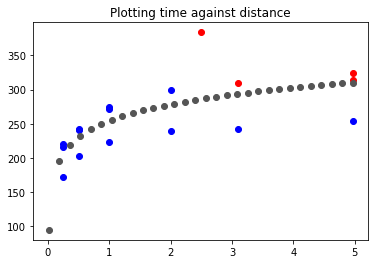

0.9


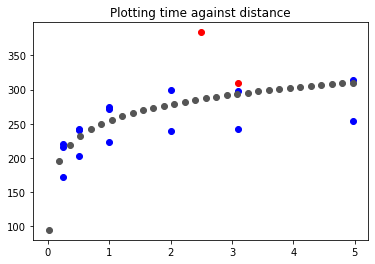

In [90]:
def curation_test_5(points):
    
    #create curator and store all points as activity wrappers
    c = curator()
    for p in points:
        c.add_activity(activity(p[0],p[1]))
    #evaluate points, sorted by value. Iterate and plot for 10 point selection sizes
    c.evaluate_all()
    for i in range(0,10,1):
        print(i/10)
    
        selected = c.select_portion(i/10)
        #fitset(spm_to_dt(selected))

        #queuefit(selected)
        queuefit(allsets) 
        c.value_plot(i/10)
curation_test_5(allsets)

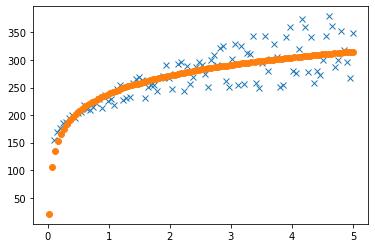

In [120]:
import random
wreq = points_to_log(wr_set)
new_set = []
for x in np.linspace(0.1,5,100):
    q = int(x*10)
    y = wreq.f(x) + 3*random.randint(0,q)
    new_set.append((x,y))
fitset(spm_to_dt(new_set))